In [21]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

In [56]:
g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [57]:
res = g.clear()

In [58]:
nodes = ["a", "b", "c", "d", "e", "f"]
edges = [("a", "b"), ("d", "b"), ("a", "c"), ("e", "a"), ("f", "d")]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

In [59]:
g.add_node("x")

In [60]:
g.add_edge("x", "c")

In [61]:
g.remove_edge("x", "c")

In [62]:
g.remove_node("x")

In [63]:
g.nodes()

['a', 'b', 'c', 'd', 'e', 'f']

In [64]:
g.edges()

[('e', 'a'), ('a', 'b'), ('d', 'b'), ('a', 'c'), ('f', 'd')]

In [65]:
res_clone_1 = g.clone_node('a')
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  a1


In [66]:
res_clone_1 = g.clone_node('a', ignore_naming=True)
print("Created clone by the name: ", res_clone_1)

Created clone by the name:  10709306


In [67]:
res_clone_2 = g.clone_node('a', 'a_clone')
print("Created clone by the name: ", res_clone_2)

Created clone by the name:  a_clone


In [55]:
res_merge = g.merge_nodes(["a", "b"])

In [35]:
res_merge

'a_b'

In [36]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z", "a"])
pattern.add_edges_from([("x", "y"), ("y", "z"), ("z", "z"), ("z", "a")])

In [42]:
instances = g.find_matching(pattern)
print("Instances: ", instances)

Instances:  []


In [38]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
clone_name2, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name2, "z")
rule.inject_remove_node("x")
rule.inject_merge_nodes(["y", "a"])
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


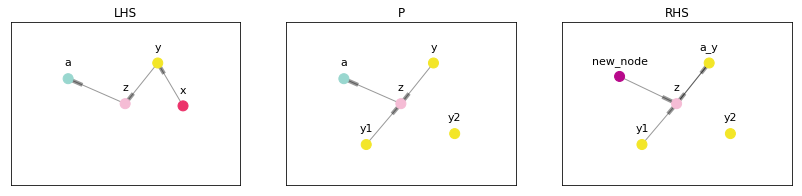

In [39]:
plot_rule(rule)

In [41]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())

IndexError: list index out of range

In [21]:
rhs_g

{'a_y': '2010854',
 'new_node': '2010855',
 'y1': '2010853',
 'y2': '2010852',
 'z': 'a_b'}

In [22]:
pattern.edges()

[('x', 'y'), ('y', 'z'), ('z', 'z'), ('z', 'a')]

In [23]:
pattern = nx.DiGraph()
pattern.add_edge("x", "y")

rule = Rule.from_transform(pattern)
rule.inject_merge_nodes(["x", "y"])

'x_y'

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


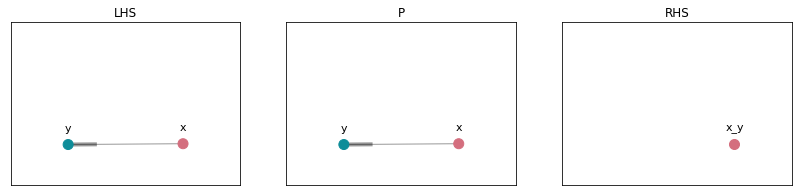

In [24]:
plot_rule(rule)

In [25]:
rhs = g.rewrite(rule, {"x": "f", "y": "d"})

CREATE (uid722dd37a9ec44d64a3bb425ef48455bf:node) SET uid722dd37a9ec44d64a3bb425ef48455bf.id=toString(id(uid722dd37a9ec44d64a3bb425ef48455bf)) WITH toString(id(uid722dd37a9ec44d64a3bb425ef48455bf)) as uid3b2510e0b12942d4bb7e97743bfe3dc0 , uid722dd37a9ec44d64a3bb425ef48455bf, preds_uid9222c226afd94d9a887d9d76bcc0ce84, sucs_uidd58c9e0988e74921a646062e35821cec, uidd58c9e0988e74921a646062e35821cec, uid9222c226afd94d9a887d9d76bcc0ce84, preds_uidd58c9e0988e74921a646062e35821cec, sucs_uid9222c226afd94d9a887d9d76bcc0ce84 


In [26]:
rhs

{'x_y': '2010857'}

In [3]:
pattern = nx.DiGraph()
pattern.add_edges_from(
    [
        ("white_circle", "square"),
        ("square", "black_circle"),
        ("triangle", "square")
    ])

In [4]:
ex_rule = Rule.from_transform(pattern)
ex_rule.inject_remove_node("traingle")
ex_rule.inject_clone_node("square")
ex_rule.inject_merge_nodes(["white_circle", "black_circle"])

'black_circle_white_circle'

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


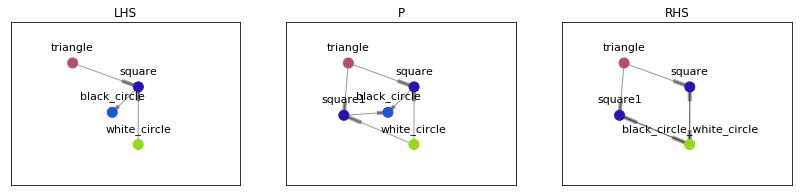

In [5]:
plot_rule(ex_rule)

In [8]:
g.rule_to_cypher(ex_rule, {"white_circle": "a", "black_circle": "b", "square": "c", "triangle": "d"})

"MATCH (uid4ba25805adaf4febbdbbb45775891c2b:node { id : 'a'}), (uide67c9708aa3a477e91ccf6bed95dc6e1:node { id : 'b'}), (uidf5523e83fd384bc0af0c94570fe9899a:node { id : 'c'}), (uidf1b8a89647d4444094117d700864456a:node { id : 'd'}) , (uid4ba25805adaf4febbdbbb45775891c2b)-[uid4ba25805adaf4febbdbbb45775891c2b_uidf5523e83fd384bc0af0c94570fe9899a:edge]->(uidf5523e83fd384bc0af0c94570fe9899a), (uidf5523e83fd384bc0af0c94570fe9899a)-[uidf5523e83fd384bc0af0c94570fe9899a_uide67c9708aa3a477e91ccf6bed95dc6e1:edge]->(uide67c9708aa3a477e91ccf6bed95dc6e1), (uidf1b8a89647d4444094117d700864456a)-[uidf1b8a89647d4444094117d700864456a_uidf5523e83fd384bc0af0c94570fe9899a:edge]->(uidf5523e83fd384bc0af0c94570fe9899a)WITH [] as ignoredNodes, uide67c9708aa3a477e91ccf6bed95dc6e1, uid4ba25805adaf4febbdbbb45775891c2b, uidf5523e83fd384bc0af0c94570fe9899a, uidf1b8a89647d4444094117d700864456a OPTIONAL MATCH (uidf5523e83fd384bc0af0c94570fe9899a)-[:edge]->(succ) OPTIONAL MATCH (pred)-[:edge]->(uidf5523e83fd384bc0af0c945